In [1]:
import os
import re
import sys
import pandas as pd
from io import StringIO

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])



import gensim
from gensim import corpora, models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [3]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/project/proquest/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 5), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.047*"window" + 0.017*"graphic" + 0.013*"application" + 0.013*"run" + '
  '0.012*"goal" + 0.011*"display" + 0.011*"screen" + 0.010*"server" + '
  '0.010*"program" + 0.009*"use"'),
 (1,
  '0.041*"not" + 0.023*"would" + 0.022*"do" + 0.019*"say" + 0.016*"be" + '
  '0.014*"think" + 0.014*"know" + 0.013*"go" + 0.012*"make" + 0.011*"people"'),
 (2,
  '0.019*"key" + 0.014*"use" + 0.012*"system" + 0.009*"information" + '
  '0.008*"provide" + 0.008*"new" + 0.007*"technology" + 0.007*"standard" + '
  '0.007*"encryption" + 0.007*"contain"'),
 (3,
  '0.014*"mission" + 0.013*"boston" + 0.012*"wing" + 0.011*"pit" + '
  '0.011*"detroit" + 0.010*"nyr" + 0.010*"la" + 0.010*"van" + 0.009*"bos" + '
  '0.009*"tor"'),
 (4,
  '0.011*"power" + 0.011*"circuit" + 0.010*"launch" + 0.009*"oil" + '
  '0.009*"king" + 0.008*"switch" + 0.007*"mon" + 0.007*"hot" + '
  '0.007*"illinois" + 0.007*"tv"'),
 (5,
  '0.022*"game" + 0.021*"team" + 0.020*"year" + 0.014*"play" + 0.012*"win" + '
  '0.012*"player" + 0.01

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.73590444221

Coherence Score:  0.588112527769


In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      22.578783        1       1 -0.343518  0.000065
7      15.851867        1       2 -0.296178  0.137895
15      5.984501        1       3 -0.088284  0.098746
11      5.187534        1       4 -0.100386 -0.185819
5       5.030988        1       5 -0.094847  0.065745
2       4.934819        1       6 -0.121783  0.020396
10      4.789653        1       7 -0.035335 -0.217570
14      4.503098        1       8  0.098832  0.032497
8       3.876197        1       9 -0.018905 -0.052069
17      3.829042        1      10 -0.034188 -0.175074
0       3.260975        1      11  0.040094  0.181093
12      3.186662        1      12  0.048562  0.087481
18      2.926117        1      13  0.055358 -0.165043
6       2.640155        1      14  0.093933  0.162303
4       2.551385        1      15  0.130975 -0.009428
13      2.259962        1      16  0.056440 -0.008012
19      2.022896        1      17  0.147029  0.046853
16      1.764760        1      18  0.111421 -0.038298
9       1.501665        1      19  0.180500  0.011688
3       1.318941        1      20  0.170280  0.006552, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4156   Default  57798.000000            ax  57798.000000  30.0000  30.0000
12     Default  12490.000000          line  12490.000000  29.0000  29.0000
8      Default  11169.000000  organization  11169.000000  28.0000  28.0000
100    Default  16414.000000           not  16414.000000  27.0000  27.0000
3724   Default   4191.000000           max   4191.000000  26.0000  26.0000
247    Default   9531.000000         write   9531.000000  25.0000  25.0000
98     Default  10519.000000            do  10519.000000  24.0000  24.0000
258    Default   6985.000000           say   6985.000000  23.0000  23.0000
140    Default  11699.000000         would  11699.000000  22.0000  22.0000
169    Default   2474.000000        window   2474.000000  21.0000  21.0000
4      Default   4420.000000     nntp_post   4420.000000  20.0000  20.0000
60     Default   7503.000000       article   7503.000000  19.0000  19.0000
259    Default   8079.000000            be   8079.000000  18.0000  18.0000
9      Default   5005.000000    university   5005.000000  17.0000  17.0000
5      Default   4087.000000          host   4087.000000  16.0000  16.0000
1840   Default   1842.000000         space   1842.000000  15.0000  15.0000
33     Default   7308.000000          know   7308.000000  14.0000  14.0000
395    Default   5082.000000        people   5082.000000  13.0000  13.0000
146    Default   6842.000000           get   6842.000000  12.0000  12.0000
137    Default   5261.000000         think   5261.000000  11.0000  11.0000
298    Default   2043.000000         drive   2043.000000  10.0000  10.0000
39     Default   3436.000000          year   3436.000000   9.0000   9.0000
301    Default   4600.000000           use   4600.000000   8.0000   8.0000
284    Default   5374.000000          good   5374.000000   7.0000   7.0000
232    Default   5842.000000            go   5842.000000   6.0000   6.0000
46     Default   2086.000000          mail   2086.000000   5.0000   5.0000
171    Default   3377.000000        system   3377.000000   4.0000   4.0000
2840   Default   1780.000000          game   1780.000000   3.0000   3.0000
954    Default   1735.000000     christian   1735.000000   2.0000   2.0000
563    Default   1692.000000          team   1692.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
8065   Topic20    214.414187            la    215.387168   4.3238  -4.5972
14491  Topic20    190.953618           bos    191.926598   4.3233  -4.7131
14477  Topic20    187.938409           tor    188.911390   4.3232  -4.7290
14479  Topic20    171.230522           det    172.203503   4.3227  -4

#### Building LDA Mallet Model

In [14]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = '' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [15]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
#coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#print('\nCoherence Score: ', coherence_ldamallet)

#### Find the optimal number of topics for LDA

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

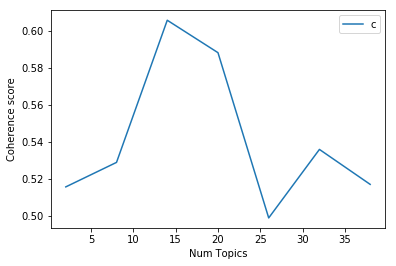

In [18]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5155
Num Topics = 8  has Coherence Value of 0.5288
Num Topics = 14  has Coherence Value of 0.6057
Num Topics = 20  has Coherence Value of 0.5881
Num Topics = 26  has Coherence Value of 0.4987
Num Topics = 32  has Coherence Value of 0.5358
Num Topics = 38  has Coherence Value of 0.5169


In [20]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.047*"window" + 0.017*"graphic" + 0.013*"application" + 0.013*"run" + '
  '0.012*"goal" + 0.011*"display" + 0.011*"screen" + 0.010*"server" + '
  '0.010*"program" + 0.009*"use"'),
 (1,
  '0.041*"not" + 0.023*"would" + 0.022*"do" + 0.019*"say" + 0.016*"be" + '
  '0.014*"think" + 0.014*"know" + 0.013*"go" + 0.012*"make" + 0.011*"people"'),
 (2,
  '0.019*"key" + 0.014*"use" + 0.012*"system" + 0.009*"information" + '
  '0.008*"provide" + 0.008*"new" + 0.007*"technology" + 0.007*"standard" + '
  '0.007*"encryption" + 0.007*"contain"'),
 (3,
  '0.014*"mission" + 0.013*"boston" + 0.012*"wing" + 0.011*"pit" + '
  '0.011*"detroit" + 0.010*"nyr" + 0.010*"la" + 0.010*"van" + 0.009*"bos" + '
  '0.009*"tor"'),
 (4,
  '0.011*"power" + 0.011*"circuit" + 0.010*"launch" + 0.009*"oil" + '
  '0.009*"king" + 0.008*"switch" + 0.007*"mon" + 0.007*"hot" + '
  '0.007*"illinois" + 0.007*"tv"'),
 (5,
  '0.022*"game" + 0.021*"team" + 0.020*"year" + 0.014*"play" + 0.012*"win" + '
  '0.012*"player" + 0.01

#### Finding the dominant topic in each sentence

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

#### Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics